In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager as fm


In [2]:
from model.model import LowLightEnhancer
from data.dataloader import LowLightDataModule
from utils.utils import save_image


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
font_path = r"times.ttf"
prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.size"] = 48


In [4]:
my_model = LowLightEnhancer(
    64,
    8,
    4,
    4,
    0.1,
    0.5,
    0.1,
)


In [5]:
checkpoint = torch.load('runs/train/version_0/checkpoints/best.ckpt', map_location='cpu', weights_only=True)
state_dict = checkpoint['state_dict']


In [6]:
new_state_dict = {}

for key, value in state_dict.items():
    if key.startswith('model.'):
        new_key = key.replace('model.', '', 1)
        new_state_dict[new_key] = value

    elif key.startswith('metric.'):
        continue

    else:
        new_state_dict[key] = value



In [7]:
my_model.load_state_dict(new_state_dict, strict=True)
my_model.eval()


LowLightEnhancer(
  (decomposition): ImageDecomposition(
    (rgb2ycrcb): RGB2YCrCbBlock()
    (homomorphic): HomomorphicSeparationBlock()
    (ycrcb2rgb): YCrCb2RGBBlock()
  )
  (feature_restorer): FeatureRestorationBlock(
    (cr_conv): DoubleConv(
      (conv1): ResidualBlock(
        (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): SiLU()
        (dropout2): Dropout(p=0.1, inplace=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (skip_proj): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (attn): SelfAttentionBlock(
        (attn): SelfAttention(
          (layer_norm): LayerNorm((64,), eps=1e-05, 

In [8]:
data_module = LowLightDataModule(
    train_dir="data/1_train",
    valid_dir="data/2_valid",
    bench_dir="data/3_bench",
    infer_dir="data/4_infer",
    image_size=256,
    batch_size=1,
    num_workers=4,
)

data_module.setup()

predict_loaders = data_module.predict_dataloader()

if isinstance(predict_loaders, (list, tuple)):
    loader = predict_loaders[0]
else:
    loader = predict_loaders
loader_iter = iter(loader)
d, _ = next(loader_iter)


In [12]:
for i in range(1, 11):
    d, _ = next(loader_iter)
    d = d.cuda()
    my_model = my_model.cuda()
    results = my_model(d)
    save_image(results["enhanced"]["rgb"], f"./result{i}.png")





In [ ]:
def topil(x, batch):
    if batch:
        return (
            (x.permute(1, 2, 0).detach().cpu().numpy() * 255)
            .clip(0, 255)
            .astype(np.uint8)
        )
    else:
        return (
            (x.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255)
            .clip(0, 255)
            .astype(np.uint8)
        )


In [ ]:
enh_rgb = results['enh_rgb']
enh_rgb = topil(enh_rgb, False)


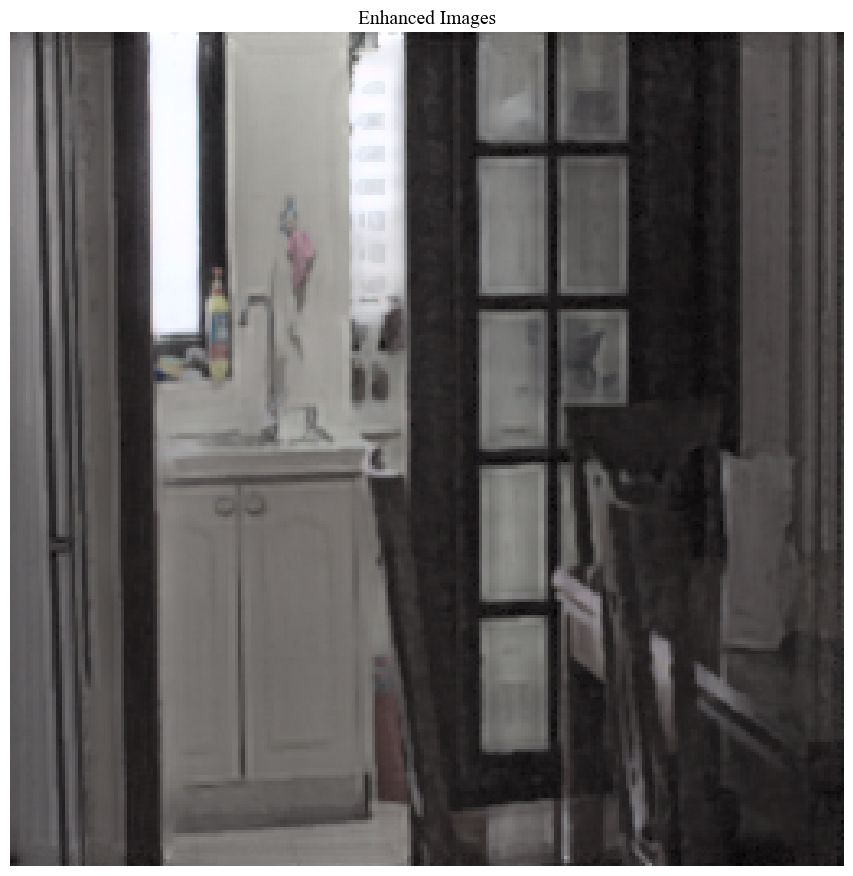

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(label="Enhanced Images", fontproperties=prop, fontsize=14)
plt.imshow(X=enh_rgb)
plt.axis(False)

plt.tight_layout()
plt.show()
